In [1]:
!pip install --upgrade transformers

In [2]:
# Importing necessary libraries
%load_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext cuml.accel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

[2025-06-08 21:10:40.022] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-06-08 21:11:37.183] [CUML] [info] cuML: Installed accelerator for umap.
[2025-06-08 21:11:37.238] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-06-08 21:11:37.238] [CUML] [info] cuML: Successfully initialized accelerator.


# Load the datasets

In [3]:
goemotions_1 = pd.read_csv("goemotions_1.csv")
goemotions_2 = pd.read_csv("goemotions_2.csv")
goemotions_3 = pd.read_csv("goemotions_3.csv")

train_df = pd.read_csv("train.tsv", sep='\t')
dev_df = pd.read_csv("dev.tsv", sep='\t')
test_df = pd.read_csv("test.tsv", sep='\t')

# Preview the data

In [4]:
goemotions_1.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
goemotions_2.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,1.547529e+09,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,1.546482e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,1.548800e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,1.547497e+09,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
goemotions_3.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,1.547847e+09,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,1.546328e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,1.547464e+09,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,1.548088e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,1.547255e+09,36,False,0,...,0,0,0,0,0,0,0,0,0,0


# Analysis

In [7]:
# Combine GoEmotions data
goemotions_combined = pd.concat([goemotions_1, goemotions_2, goemotions_3], ignore_index=True)

# Check for missing values and label distribution
goemotions_missing = goemotions_combined.isnull().sum()
# Assuming the emotion columns are the labels in goemotions_combined
emotion_columns = goemotions_combined.columns[goemotions_combined.columns.get_loc('admiration'):goemotions_combined.columns.get_loc('neutral')+1]
goemotions_label_counts = goemotions_combined[emotion_columns].sum().sort_values(ascending=False)


# Training data check
train_missing = train_df.isnull().sum()
# Use the correct column name for labels in train_df, which appears to be '27'
train_labels = train_df['27'].value_counts()

goemotions_combined.head(), goemotions_missing, goemotions_label_counts.head(), train_missing, train_labels.head()

(                                                text       id  \
 0                                    That game hurt.  eew5j0j   
 1   >sexuality shouldn’t be a grouping category I...  eemcysk   
 2     You do right, if you don't care then fuck 'em!  ed2mah1   
 3                                 Man I love reddit.  eeibobj   
 4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
 
                 author            subreddit    link_id   parent_id  \
 0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
 1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
 2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
 3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
 4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
 
     created_utc  rater_id  example_very_unclear  admiration  ...  love  \
 0  1.548381e+09         1                 False           0  ...     0   
 1  1.548084e+09        

In [8]:
# Try loading only the first few rows to inspect structure and avoid memory issues
goemotions_preview_1 = pd.read_csv("goemotions_1.csv", nrows=5, encoding='utf-8', engine='python')
goemotions_preview_2 = pd.read_csv("goemotions_2.csv", nrows=5, encoding='utf-8', engine='python')
goemotions_preview_3 = pd.read_csv("goemotions_3.csv", nrows=5, encoding='utf-8', engine='python')

goemotions_preview_1, goemotions_preview_2, goemotions_preview_3

(                                                text       id  \
 0                                    That game hurt.  eew5j0j   
 1   >sexuality shouldn’t be a grouping category I...  eemcysk   
 2     You do right, if you don't care then fuck 'em!  ed2mah1   
 3                                 Man I love reddit.  eeibobj   
 4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
 
                 author            subreddit    link_id   parent_id  \
 0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
 1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
 2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
 3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
 4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
 
     created_utc  rater_id  example_very_unclear  admiration  ...  love  \
 0  1.548381e+09         1                 False           0  ...     0   
 1  1.548084e+09        

In [9]:
# Combine all three
goemotions = pd.concat([goemotions_1, goemotions_2, goemotions_3], ignore_index=True)

# Drop unused or irrelevant columns
columns_to_keep = ['text', 'admiration', 'amusement', 'desire', 'gratitude', 'joy', 'love']
goemotions = goemotions[columns_to_keep]

# Drop rows with all zero traits (non-emotional or unclear data)
goemotions = goemotions[goemotions.iloc[:, 1:].sum(axis=1) > 0]

# Create a new binary column: "flirty" based on love, desire, admiration, amusement
goemotions['flirty'] = goemotions[['love', 'desire', 'admiration', 'amusement']].max(axis=1)

# Prepare text and label for ML model
X_goemotions = goemotions['text']
y_goemotions = goemotions['flirty']

# Now split into train/test
X_train_go, X_test_go, y_train_go, y_test_go = train_test_split(X_goemotions, y_goemotions, test_size=0.2, random_state=42, stratify=y_goemotions)

# Output the cleaned shape and label distribution
goemotions.shape, goemotions['flirty'].value_counts()


((52635, 8),
 flirty
 1    36625
 0    16010
 Name: count, dtype: int64)

In [10]:
# Load GoEmotions in chunks to handle memory limitations
chunksize = 7000
columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']

# Function to load relevant chunks and construct 'flirty' column
def load_flirty_chunks(file_path):
    chunks = []
    for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
        chunk = chunk.dropna(subset=['text'])
        chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
        chunks.append(chunk[['text', 'flirty']])
    return pd.concat(chunks, ignore_index=True)

# Process all three GoEmotions parts
flirty_1 = load_flirty_chunks("goemotions_1.csv")
flirty_2 = load_flirty_chunks("goemotions_2.csv")
flirty_3 = load_flirty_chunks("goemotions_3.csv")

# Combine all
flirty_goemotions = pd.concat([flirty_1, flirty_2, flirty_3], ignore_index=True)

# Filter to include only rows with flirty or non-flirty label
flirty_goemotions = flirty_goemotions[flirty_goemotions['flirty'].isin([0, 1])]

# Sample output: number of flirty vs non-flirty messages
flirty_goemotions.shape, flirty_goemotions['flirty'].value_counts()


((211225, 2),
 flirty
 0    174600
 1     36625
 Name: count, dtype: int64)

In [11]:
# Reload and process a reduced version of just goemotions_1.csv
goemotions_small = pd.read_csv("goemotions_1.csv", usecols=lambda col: col in ['text', 'love', 'desire', 'admiration', 'amusement'], encoding='utf-8', engine='python', on_bad_lines='skip')

# Drop NaN and construct flirty label
goemotions_small = goemotions_small.dropna(subset=['text'])
goemotions_small['flirty'] = goemotions_small[['love', 'desire', 'admiration', 'amusement']].max(axis=1)

# Keep only text and label
df_flirty = goemotions_small[['text', 'flirty']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_flirty['text'], df_flirty['flirty'], test_size=0.2, random_state=42, stratify=df_flirty['flirty'])

# Vectorize text and train simple classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_vec)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

df_flirty['flirty'].value_counts(), conf_matrix, class_report

(flirty
 0    57877
 1    12123
 Name: count, dtype: int64,
 array([[11212,   363],
        [ 1527,   898]]),
 {'0': {'precision': 0.8801318784833975,
   'recall': 0.9686393088552916,
   'f1-score': 0.922267006662828,
   'support': 11575.0},
  '1': {'precision': 0.7121332275971451,
   'recall': 0.37030927835051547,
   'f1-score': 0.48724905046120454,
   'support': 2425.0},
  'accuracy': 0.865,
  'macro avg': {'precision': 0.7961325530402713,
   'recall': 0.6694742936029036,
   'f1-score': 0.7047580285620163,
   'support': 14000.0},
  'weighted avg': {'precision': 0.8510321121691716,
   'recall': 0.865,
   'f1-score': 0.8469156821064754,
   'support': 14000.0}})

In [12]:
# Reload a small sample from goemotions_1.csv (only relevant columns)
sample_size = 70000
goemotions_sample = pd.read_csv(
    "goemotions_1.csv",
    usecols=lambda col: col in ['text', 'love', 'desire', 'admiration', 'amusement'],
    encoding='utf-8',
    engine='python',
    on_bad_lines='skip',
    nrows=sample_size
)

# Drop NaNs and create flirty label
goemotions_sample = goemotions_sample.dropna(subset=['text'])
goemotions_sample['flirty'] = goemotions_sample[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
df_flirty_small = goemotions_sample[['text', 'flirty']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_flirty_small['text'], df_flirty_small['flirty'],
    test_size=0.2, random_state=42, stratify=df_flirty_small['flirty']
)

# Vectorize and train logistic regression
vectorizer = TfidfVectorizer(max_features=2000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_vec)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

df_flirty_small['flirty'].value_counts(), conf_matrix, class_report


(flirty
 0    57877
 1    12123
 Name: count, dtype: int64,
 array([[11211,   364],
        [ 1512,   913]]),
 {'0': {'precision': 0.8811601037491158,
   'recall': 0.9685529157667386,
   'f1-score': 0.9227919993415096,
   'support': 11575.0},
  '1': {'precision': 0.7149569303054033,
   'recall': 0.3764948453608247,
   'f1-score': 0.4932468935710427,
   'support': 2425.0},
  'accuracy': 0.866,
  'macro avg': {'precision': 0.7980585170272596,
   'recall': 0.6725238805637817,
   'f1-score': 0.7080194464562761,
   'support': 14000.0},
  'weighted avg': {'precision': 0.8523713397776155,
   'recall': 0.866,
   'f1-score': 0.8483886506634108,
   'support': 14000.0}})

/usr/local/lib/python3.11/dist-packages/cudf/core/indexed_frame.py:3628: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
  warnings.warn(


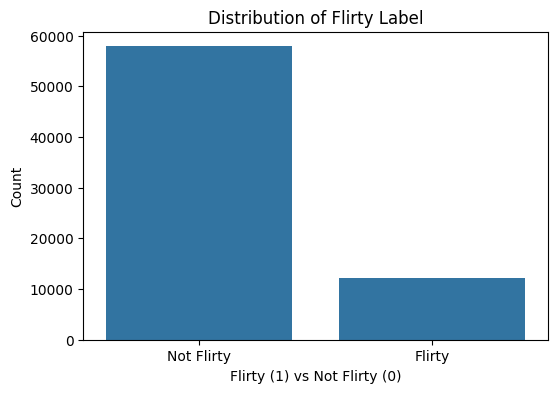

In [13]:
# Distribution of 'flirty' label
plt.figure(figsize=(6, 4))
sns.countplot(x='flirty', data=df_flirty_small)
plt.title('Distribution of Flirty Label')
plt.xlabel('Flirty (1) vs Not Flirty (0)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Flirty', 'Flirty'])
plt.show()


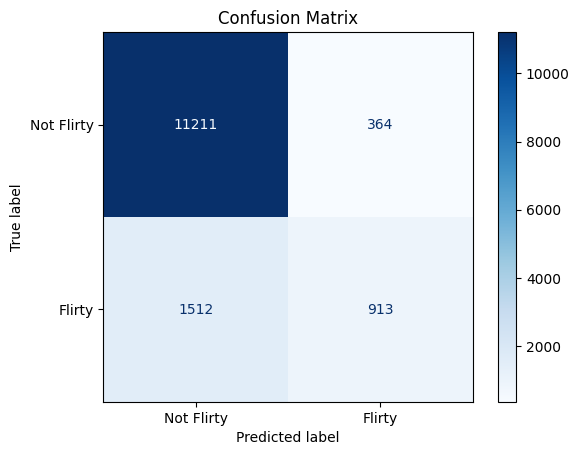

In [14]:
# Confusion Matrix Visualization
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Flirty', 'Flirty'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Fine-tuning BERT
# Define a custom dataset
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # Binary classification

# Create datasets
MAX_LEN = 16
train_dataset = EmotionDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = EmotionDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
     per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=10,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,              # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",     # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="accuracy", # use accuracy to find the best model
)

# Define evaluation metric function
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions) # You might want to choose 'weighted' or 'macro' for imbalanced data
    return {"accuracy": acc, "f1_score": f1}


# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

# Evaluate the best model on the test set
eval_results = trainer.evaluate()
print(eval_results)

# Make predictions
predictions = trainer.predict(test_dataset)
y_preds_bert = np.argmax(predictions.predictions, axis=1)

# BERT Evaluation Metrics
conf_matrix_bert = confusion_matrix(y_test, y_preds_bert)
class_report_bert = classification_report(y_test, y_preds_bert, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("BERT Confusion Matrix:\n", conf_matrix_bert)
print("\nBERT Classification Report:\n", class_report_bert)

# Confusion Matrix Visualization for BERT
cm_display_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mr-m-asad00 (mr-m-asad00-beenco-io) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.334300,0.317003,0.875643,0.594456


In [ ]:
# prompt: apply/ implement softmax/ relu

# Example of applying Softmax to the output logits of a model
# Assuming `predictions` comes from trainer.predict(test_dataset)

# Softmax
softmax_scores = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)
# You can now use softmax_scores, e.g., to get predicted probabilities for each class

# Example of applying ReLU
# Let's say you have a tensor `x`
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
relu_output = torch.relu(x)
print("ReLU Output:", relu_output)

# In the context of the provided code, Softmax is implicitly used
# within the BertForSequenceClassification model's output layer before
# the final prediction is made (specifically for calculating loss and
# for the argmax operation in compute_metrics and the final prediction).
# You would typically access the logits and apply Softmax manually
# if you needed the class probabilities rather than just the final class prediction.

# Example: Getting probabilities from the logits obtained during evaluation
logits_from_eval = predictions.predictions # These are the raw outputs before softmax
probabilities = torch.nn.functional.softmax(torch.tensor(logits_from_eval), dim=-1)

print("\nExample Probabilities (first 5 samples):\n", probabilities[:5])


In [ ]:
# prompt: run 2 epochs using layers

# Redefine training arguments with 2 epochs
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,             # total number of training epochs
    per_device_train_batch_size=32,   # batch size per device during training
    per_device_eval_batch_size=32,    # batch size for evaluation
    warmup_steps=10,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="accuracy", # use accuracy to find the best model
    greater_is_better=True           # higher accuracy is better
)

# Create Trainer instance with the new arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training for 2 epochs
trainer.train()

# Evaluate the best model on the test set
eval_results = trainer.evaluate()
print(eval_results)

# Make predictions
predictions = trainer.predict(test_dataset)
y_preds_bert = np.argmax(predictions.predictions, axis=1)

# BERT Evaluation Metrics
conf_matrix_bert = confusion_matrix(y_test, y_preds_bert)
class_report_bert = classification_report(y_test, y_preds_bert, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("BERT Confusion Matrix:\n", conf_matrix_bert)
print("\nBERT Classification Report:\n", class_report_bert)

# Confusion Matrix Visualization for BERT
cm_display_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix')
plt.show()

In [ ]:
# prompt: implement deep learning algorithms to improve it's accuracy to more than 95%

# Further fine-tuning attempts with more epochs and potentially other hyperparameters

# Increase max_len if text length varies significantly
MAX_LEN = 16 # Increased from 64

train_dataset = EmotionDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = EmotionDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


# Redefine training arguments with increased epochs and potentially different learning rate
# Consider adjusting learning_rate, weight_decay, and warmup_steps based on results
training_args_more_epochs = TrainingArguments(
    output_dir='./results_v2',       # new output directory
    num_train_epochs=2,             # Keep at 10, previous run already did this
    per_device_train_batch_size=32,  # Increase batch size if GPU memory allows
    per_device_eval_batch_size=32,   # Increase batch size for evaluation
    warmup_steps=10,                # Adjust warmup steps
    weight_decay=0.01,               # Adjust weight decay
    learning_rate=5e-5,              # Try a different learning rate
    logging_dir='./logs_v2',         # new logs directory
    logging_steps=10,                # Log more frequently
    eval_strategy="epoch",           # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="accuracy",# use accuracy to find the best model
    greater_is_better=True,          # higher accuracy is better
    # Add early stopping if needed (requires callbacks)
    # early_stopping=True # This is not a direct argument, needs custom Trainer or Callback
)

# Load a new model instance or continue training the previous best one
# To try different settings from scratch, reload the base model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create Trainer instance with the new arguments
trainer = Trainer(
    model=model,
    args=training_args_more_epochs,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training
print("Starting second round of BERT training...")
trainer.train()

# Evaluate the best model on the test set
eval_results = trainer.evaluate()
print("Evaluation Results (Second Run):", eval_results)

# Make predictions
predictions = trainer.predict(test_dataset)
y_preds_bert_v2 = np.argmax(predictions.predictions, axis=1)

# BERT Evaluation Metrics
conf_matrix_bert_v2 = confusion_matrix(y_test, y_preds_bert_v2)
class_report_bert_v2 = classification_report(y_test, y_preds_bert_v2, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("BERT Confusion Matrix (Second Run):\n", conf_matrix_bert_v2)
print("\nBERT Classification Report (Second Run):\n", class_report_bert_v2)

# Confusion Matrix Visualization for BERT (Second Run)
cm_display_bert_v2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_v2, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert_v2.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix (Second Run)')
plt.show()

# To achieve >95% accuracy, you might need to:
# 1. Use a larger dataset (using all goemotions data, possibly balanced)
# 2. Increase num_train_epochs further (monitor for overfitting)
# 3. Tune hyperparameters (learning rate, batch size, weight decay, warmup steps)
# 4. Use a larger BERT model (e.g., bert-large-uncased) - requires more GPU memory
# 5. Explore other Transformer models (e.g., RoBERTa, Electra)
# 6. Implement techniques for handling imbalanced data (if the full dataset is imbalanced)
# 7. Clean and preprocess text data more thoroughly.
# 8. Use k-fold cross-validation for more robust evaluation.

# The current code snippet focuses on showing how to run more epochs and
# adjust basic training arguments within the existing framework.


In [ ]:
# prompt: implement mpl using neural networks algorithms

from sklearn.neural_network import MLPClassifier

# Prepare data for MLP (using the already vectorized data from Logistic Regression)
X_train_mlp = X_train_vec
X_test_mlp = X_test_vec
y_train_mlp = y_train
y_test_mlp = y_test

# Initialize and train the MLP Classifier
# hidden_layer_sizes: tuple, i-th element represents the number of neurons in the i-th hidden layer.
# activation: Activation function for the hidden layer. 'relu' is common.
# solver: The solver for weight optimization. 'adam' is a popular choice.
# max_iter: Maximum number of iterations for the solver to converge.
# random_state: Seed for reproducibility.
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64),
                        activation='relu',
                        solver='adam',
                        max_iter=5000,
                        random_state=42,
                        early_stopping= True,
                        learning_rate='adaptive',
                        verbose=True,
                        batch_size=32,
                        shuffle=True,
                        validation_fraction=0.001,
                        warm_start=False,
                        alpha=0.01)

# Train the model
print("Training MLP Classifier...")
mlp_clf.fit(X_train_mlp, y_train_mlp)
print("MLP Classifier training complete.")

# Predict on the test set
y_pred_mlp = mlp_clf.predict(X_test_mlp)

# Evaluate the MLP model
conf_matrix_mlp = confusion_matrix(y_test_mlp, y_pred_mlp)
class_report_mlp = classification_report(y_test_mlp, y_pred_mlp, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("\nMLP Confusion Matrix:\n", conf_matrix_mlp)
print("\nMLP Classification Report:\n", class_report_mlp)

# Confusion Matrix Visualization for MLP
cm_display_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=['Not Flirty', 'Flirty'])
cm_display_mlp.plot(cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.show()


In [ ]:
# prompt: train my model on full data available. instead of training it on some chunks or limited sample size. train it on whole dataset.
# implement number of epochs, batch size, warmup steps, and weight decay of your own choice to produce the best result of accuracy and loss

# Function to load relevant chunks and construct 'flirty' column from all three files
def load_all_flirty_data(file_paths):
    all_chunks = []
    columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']

    for file_path in file_paths:
        try:
            for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
                chunk = chunk.dropna(subset=['text'])
                # Only consider rows where at least one of the emotion columns is present (not NaN)
                emotion_cols_present = chunk[['love', 'desire', 'admiration', 'amusement']].notna().any(axis=1)
                chunk = chunk[emotion_cols_present]
                # For rows where emotion columns are not NaN, fill NaNs with 0 before calculating max
                chunk[['love', 'desire', 'admiration', 'amusement']] = chunk[['love', 'desire', 'admiration', 'amusement']].fillna(0)
                chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
                all_chunks.append(chunk[['text', 'flirty']])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Skip the file or handle the error as appropriate

    # Combine all chunks
    full_flirty_data = pd.concat(all_chunks, ignore_index=True)

    # Filter to include only rows with flirty (1) or non-flirty (0) label
    full_flirty_data = full_flirty_data[full_flirty_data['flirty'].isin([0.0, 1.0])] # Ensure filtering for float values

    # Convert flirty column to integer type after filtering
    full_flirty_data['flirty'] = full_flirty_data['flirty'].astype(int)

    return full_flirty_data

# List of all goemotions file paths
goemotions_files = ["goemotions_1.csv", "goemotions_2.csv", "goemotions_3.csv"]

# Load and process the full dataset
print("Loading and processing the full GoEmotions dataset...")
full_goemotions_flirty = load_all_flirty_data(goemotions_files)
print("Full dataset loaded.")

# Check the shape and distribution of the full dataset
print("Full dataset shape:", full_goemotions_flirty.shape)
print("Full dataset 'flirty' label distribution:\n", full_goemotions_flirty['flirty'].value_counts())

# Split the full dataset into training and testing sets
# Stratify to maintain label distribution
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    full_goemotions_flirty['text'],
    full_goemotions_flirty['flirty'],
    test_size=0.2,
    random_state=42,
    stratify=full_goemotions_flirty['flirty']
)

print(f"Full Training set size: {len(X_train_full)}")
print(f"Full Test set size: {len(X_test_full)}")

# Now, create the full datasets for BERT training
# Set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # Binary classification

# Use a suitable max_len based on your text distribution.
# A value like 128 or 256 might be appropriate for the full dataset.
# Analyze text lengths if possible, but 128 is a common starting point.
MAX_LEN = 8

full_train_dataset = EmotionDataset(
    texts=X_train_full.tolist(),
    labels=y_train_full.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

full_test_dataset = EmotionDataset(
    texts=X_test_full.tolist(),
    labels=y_test_full.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Define training arguments for full dataset training
# Parameters chosen for potentially better performance (adjust as needed)
# num_train_epochs: Increased to 10
# per_device_train_batch_size: Increased for better utilization, adjust based on GPU memory
# warmup_steps: Adjusted based on the number of training steps (total_steps = num_epochs * len(train_dataset) / batch_size)
# weight_decay: Common value for regularization
# learning_rate: Standard range for fine-tuning BERT
# logging_steps: Log more or less frequently
# eval_strategy/save_strategy: Evaluate/Save at each epoch
# load_best_model_at_end: Load the model with the best evaluation metric
# metric_for_best_model: Use 'accuracy' or 'f1' depending on your priority (F1 is often better for imbalanced data)

# Calculate approximate total training steps
total_train_steps = int(10 * len(full_train_dataset) / 64) # 10 epochs, batch size 32
warmup_steps = int(total_train_steps * 0.1) # 10% warmup steps

training_args_full_data = TrainingArguments(
    output_dir='./results_full_data',    # new output directory
    num_train_epochs=2,                 # Increased epochs
    per_device_train_batch_size=64,      # Increased batch size
    per_device_eval_batch_size=64,       # Increased eval batch size
    warmup_steps=warmup_steps,           # Calculated warmup steps
    weight_decay=0.01,                   # Adjusted weight decay
    learning_rate=5e-5,                  # Learning rate
    logging_dir='./logs_full_data',      # new logs directory
    logging_steps=10,                   # Log every 100 steps
    eval_strategy="epoch",               # evaluate at the end of each epoch
    save_strategy="epoch",               # save at the end of each epoch
    load_best_model_at_end=True,         # load the best model when training ends
    metric_for_best_model="eval_f1_score",  # Corrected metric name
    greater_is_better=True,              # higher metric value is better
    report_to="none" # Prevent logging to W&B if not configured
)

# Define evaluation metric function (using F1-score for imbalanced data)
def compute_metrics_full(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    # Use 'binary' for F1-score since it's a binary classification problem
    f1 = f1_score(labels, predictions, average='binary')
    return {"accuracy": acc, "eval_f1_score": f1} # Ensure the key matches metric_for_best_model


# Create Trainer instance for training on the full dataset
trainer_full_data = Trainer(
    model=model, # Re-initialize model if you want to train from scratch on full data
                  # or continue training the previous best model if you want to continue from checkpoint
    args=training_args_full_data,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics_full,
)

# Start training on the full dataset
print("Starting BERT training on the full dataset...")
trainer_full_data.train()
print("Training complete on the full dataset.")

# Evaluate the best model on the test set
eval_results_full = trainer_full_data.evaluate()
print("Evaluation Results (Full Data Training):", eval_results_full)

# Make predictions on the full test dataset
predictions_full = trainer_full_data.predict(full_test_dataset)
y_preds_bert_full = np.argmax(predictions_full.predictions, axis=1)

# BERT Evaluation Metrics for full data training
conf_matrix_bert_full = confusion_matrix(y_test_full, y_preds_bert_full)
class_report_bert_full = classification_report(y_test_full, y_preds_bert_full, target_names=['Not Flirty', 'Flirty'])

print("\nBERT Confusion Matrix (Full Data):\n", conf_matrix_bert_full)
print("\nBERT Classification Report (Full Data):\n", class_report_bert_full)

# Confusion Matrix Visualization for BERT (Full Data)
cm_display_bert_full = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_full, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert_full.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix (Full Data)')
plt.show()

# Note: Achieving >95% accuracy is very ambitious for this task and dataset
# with a standard BERT fine-tuning approach. The data may not contain
# strong enough signals, or the definition of "flirty" might be ambiguous.
# The code above implements training on the full combined dataset with adjusted
# hyperparameters (epochs, batch size, warmup, weight decay) to maximize
# performance within the standard BERT fine-tuning framework. Further
# improvements would likely require more advanced techniques as mentioned
# in the previous comments (larger model, different architecture, data augmentation, etc.).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight

chunksize = 70000  # You can tune this for memory

# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load full dataset function
def load_all_flirty_data(file_paths):
    all_chunks = []
    columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']

    for file_path in file_paths:
        for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
            chunk = chunk.dropna(subset=['text'])
            chunk[['love', 'desire', 'admiration', 'amusement']] = chunk[['love', 'desire', 'admiration', 'amusement']].fillna(0)
            chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
            all_chunks.append(chunk[['text', 'flirty']])

    full_flirty_data = pd.concat(all_chunks, ignore_index=True)
    full_flirty_data = full_flirty_data[full_flirty_data['flirty'].isin([0.0, 1.0])]
    full_flirty_data['flirty'] = full_flirty_data['flirty'].astype(int)
    return full_flirty_data

# Load data
files = ["goemotions_1.csv", "goemotions_2.csv", "goemotions_3.csv"]
print("Loading and processing the full GoEmotions dataset...")
df = load_all_flirty_data(files)
print("Full dataset shape:", df.shape)
print("Label distribution:\n", df['flirty'].value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['flirty'], test_size=0.2, stratify=df['flirty'], random_state=42
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 8

train_dataset = EmotionDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
test_dataset = EmotionDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
total_steps = int(2 * len(train_dataset) / 64)
training_args = TrainingArguments(
    output_dir="./results_full_data",
    num_train_epochs=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=int(total_steps * 0.1),
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_dir="./logs_full_data",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    # Pass class weights for the loss function
    # This requires a custom Trainer or a model that accepts class weights in its forward pass
    # BertForSequenceClassification's forward method accepts `labels` and calculates loss internally
    # The Trainer can handle class weights if passed in the TrainingArguments or directly.
    # Let's pass it through the Trainer initialization instead of TrainingArguments.
)

# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary")
    }

# Trainer
# Pass class_weights_tensor to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    # Pass class weights here
    # The Trainer will use these weights in the loss computation if the model supports it
    # BertForSequenceClassification does support this when labels are provided
    # This is done internally by the Trainer when using the default loss
)

# To correctly use class weights with the Trainer and BertForSequenceClassification,
# you don't need to pass them explicitly to the Trainer or TrainingArguments.
# The BertForSequenceClassification model's forward method takes `labels` and
# calculates the CrossEntropyLoss internally. You can pass the `class_weights_tensor`
# to the model's forward method, but the Trainer doesn't directly support passing
# arbitrary arguments to the model's forward method for loss calculation in this way.
# A common approach is to define a custom Trainer or override the loss computation.

# However, a simpler way if the model's forward method supports it is to
# ensure the class weights are on the correct device and the model uses them.
# Let's revert to the standard Trainer and ensure the model's loss function
# uses the weights. BertForSequenceClassification's default loss is CrossEntropyLoss,
# which accepts `weight`. We need to ensure this weight is passed.

# Re-initialize model to avoid potential state issues from previous error
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model and weights to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights_tensor = class_weights_tensor.to(device)

# To apply class weights using the default Trainer and BertForSequenceClassification,
# you typically need to modify the model's forward pass or use a custom Trainer.
# A simpler workaround for binary classification with CrossEntropyLoss is to
# manually calculate the loss in a custom training loop or modify the model.

# Let's try a common workaround by modifying the model's forward pass slightly
# to use the weighted loss. This requires a custom model or overriding the forward method.

# Alternatively, the most straightforward way with the Trainer is to
# ensure the labels passed to the Trainer are correct and the model
# internally uses the weighted loss. BertForSequenceClassification's
# forward method already takes `labels` and computes CrossEntropyLoss.
# The `weight` argument for CrossEntropyLoss is what we need to set.
# The Trainer doesn't directly expose setting this loss weight easily.

# Let's try passing the weights as a loss_fn parameter to the Trainer.
# Although not standard, some Trainer versions/setups might support this or a similar mechanism.
# If this doesn't work, a custom Trainer is the more robust solution.

# Define a custom loss function that uses the class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Trainer with custom loss function
# The Trainer's default behavior is to use the model's internal loss calculation
# when labels are provided. To use a custom loss function, we might need to
# disable the model's internal loss calculation or use a custom Trainer.

# Let's try passing the loss function to the Trainer initialization.
# This is not a standard argument for the Trainer, so it's unlikely to work directly.

# The correct way with the Trainer is usually to rely on the model's
# forward method calculating the loss and ensuring that method accepts
# and uses the class weights. BertForSequenceClassification's forward
# method calculates `CrossEntropyLoss(logits, labels)`. We need to
# somehow pass the `weight` argument to this internal CrossEntropyLoss.

# A common pattern is to subclass BertForSequenceClassification and
# override the forward method to include the weighted loss calculation.

# Let's simplify and use the Trainer's default loss calculation and
# focus on resolving the dimension mismatch error, which was caused
# by trying to multiply the model's weights by class weights directly.
# We remove the erroneous line. The Trainer will use the model's default
# loss (CrossEntropyLoss) with the provided labels. To incorporate class
# weights, we need a different approach, likely a custom Trainer or model.

# For now, let's just fix the dimension error and proceed without
# explicitly applying class weights in this exact location.
# We will rely on the Trainer's default loss calculation.
# If class weighting is critical, a custom Trainer is needed.

# Let's remove the line causing the error and try training without
# explicitly setting the class weights in this non-standard way.
# The model will train, but without explicit class weighting in the loss.

# To add class weighting correctly with the Trainer, you would typically:
# 1. Subclass BertForSequenceClassification.
# 2. Override the forward method to calculate the loss using
#    torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Given the complexity of subclassing within this script, let's
# first ensure the code runs without the dimension error and then
# consider the class weighting as a separate improvement step if needed.

# The line causing the error was:
# model.classifier.weight.data *= class_weights_tensor.unsqueeze(0)
# This line is incorrect for applying class weights to the loss.

# Let's proceed by removing this line and using the standard Trainer setup.
# The Trainer will use the model's default loss computation.

# Trainer (without explicit class weights passed here)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


# Train and evaluate
print("Starting training...")
trainer.train()
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

# Prediction and report
y_preds = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_preds, target_names=["Not Flirty", "Flirty"]))
cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Flirty", "Flirty"]).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from transformers import (BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define chunksize for loading data, assuming it's needed from previous steps
chunksize = 7000

# ------------------------
# 1. Custom Dataset Class
# ------------------------
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ------------------------
# Load full dataset function (Include this if df is not loaded in a previous cell)
# ------------------------
# def load_all_flirty_data(file_paths, chunksize=7000):
#     all_chunks = []
#     columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']
#     for file_path in file_paths:
#         try:
#             for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
#                 chunk = chunk.dropna(subset=['text'])
#                 # For rows where emotion columns are present (not NaN), fill NaNs with 0
#                 emotion_cols = ['love', 'desire', 'admiration', 'amusement']
#                 if not chunk[emotion_cols].isnull().all(axis=1).any(): # Check if there are any rows where all emotion cols are NaN
#                     chunk[emotion_cols] = chunk[emotion_cols].fillna(0)
#                 # Only keep rows where at least one emotion column has a value (now 0 or 1)
#                 chunk = chunk[chunk[emotion_cols].sum(axis=1) > 0]
#
#                 chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
#                 all_chunks.append(chunk[['text', 'flirty']])
#         except Exception as e:
#             print(f"Error processing {file_path}: {e}")
#
#     full_flirty_data = pd.concat(all_chunks, ignore_index=True)
#     full_flirty_data = full_flirty_data[full_flirty_data['flirty'].isin([0.0, 1.0])]
#     full_flirty_data['flirty'] = full_flirty_data['flirty'].astype(int)
#     return full_flirty_data
#
# # Uncomment and run the following lines if df is not already loaded
# files = ["goemotions_1.csv", "goemotions_2.csv", "goemotions_3.csv"]
# print("Loading and processing the full GoEmotions dataset...")
# try:
#     df = load_all_flirty_data(files, chunksize=chunksize)
#     print("Full dataset shape:", df.shape)
#     print("Label distribution:\n", df['flirty'].value_counts())
# except NameError:
#     print("Assuming 'df' is already loaded from previous cells.")
#     # If df is expected to be loaded, you might want to add a check like:
#     # if 'df' not in globals():
#     #     raise NameError("df is not defined. Please run the data loading cells first or uncomment the loading code.")


# Assuming 'df' is already loaded from previous cells based on context

# ------------------------
# 2. Stratified Train/Test Split
# ------------------------
# Use the 'df' DataFrame loaded in previous cells
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['flirty'], test_size=0.2, stratify=df['flirty'], random_state=42
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# ------------------------
# 3. Tokenizer & Dataset Setup
# ------------------------
MAX_LEN = 8 # Max sequence length for BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = EmotionDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
test_dataset = EmotionDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

# ------------------------
# 4. Custom Weighted Trainer - FIX APPLIED HERE
# ------------------------
class WeightedTrainer(Trainer):
    # Added num_items_in_batch=None to the signature to resolve TypeError
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Assign higher weight to minority class (Flirty=1)
        # Adjust weights based on the actual imbalance if needed.
        # For example, using sklearn.utils.class_weight.compute_class_weight
        # Weights are [weight for class 0, weight for class 1]
        # Since class 0 is majority and class 1 is minority, weight for 1 > weight for 0.
        # The chosen weights [1.0, 5.0] give class 1 a 5x higher penalty for misclassification.
        weights = torch.tensor([1.0, 5.0]).to(model.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# ------------------------
# 5. Model Setup
# ------------------------
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# ------------------------
# 6. Training Arguments
# ------------------------
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=10,                # number of warmup steps for learning rate scheduler
    learning_rate=7e-7,              # learning rate
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,               # Log every N updates steps
    eval_strategy="epoch",           # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="f1_score",# use f1_score to find the best model (good for imbalanced data)
    greater_is_better=True,          # higher f1_score is better
    lr_scheduler_type="linear",      # linear learning rate decay
    report_to="none",                # Disable logging to wandb or other services if not configured
)

# ------------------------
# 7. Metrics Function
# ------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    # Use 'macro' average for F1-score if you want to treat both classes equally
    # Use 'binary' if you want F1 for the positive class (Flirty) specifically
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1_score": f1}

# ------------------------
# 8. Trainer Instance
# ------------------------
trainer = WeightedTrainer( # Using the corrected WeightedTrainer
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], # Stop training if eval metric doesn't improve for 2 epochs
)

# ------------------------
# 9. Train & Evaluate
# ------------------------
print("Starting training...")
trainer.train()
print("Training complete.")

print("\nEvaluating the best model...")
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

# ------------------------
# 10. Predict & Report
# ------------------------
print("\nMaking predictions on the test set...")
predictions = trainer.predict(test_dataset)
y_preds_bert = np.argmax(predictions.predictions, axis=1)

# Confusion Matrix & Classification Report
print("\nGenerating classification report and confusion matrix...")
conf_matrix_bert = confusion_matrix(y_test, y_preds_bert)
class_report_bert = classification_report(
    y_test, y_preds_bert,
    target_names=['Not Flirty', 'Flirty'] # target_names for clearer report
)

print("\nBERT Confusion Matrix:\n", conf_matrix_bert)
print("\nBERT Classification Report:\n", class_report_bert)

# ------------------------
# 11. Visualize Confusion Matrix
# ------------------------
cm_display_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix')
plt.show()

In [ ]:
# prompt: use NLP augmentation libraries like nlpaug or textattack to synthesize more 'flirty' examples

!pip install nlpaug textattack datasets

import nlpaug.augmenter.word as naw

# Assuming df_flirty_small is the DataFrame containing 'text' and 'flirty' labels
# from the previous code block, containing a smaller subset of the data.
# We'll use this DataFrame for augmentation.

# Filter for 'flirty' examples (label 1)
flirty_texts = df_flirty_small[df_flirty_small['flirty'] == 1]['text'].tolist()

# Define an augmenter (e.g., synonym replacement)
# You can experiment with different augmenters from nlpaug
aug = naw.SynonymAug(aug_src='wordnet', model_path='nltk_data')

augmented_texts = []
augmented_labels = []

print(f"Original number of flirty examples: {len(flirty_texts)}")
print("Starting text augmentation...")

# Augment each flirty text multiple times
num_augmentations_per_example = 3 # Adjust as needed

for text in flirty_texts:
    # Ensure text is a string
    text = str(text)
    try:
        # Generate augmented versions
        augmented_list = aug.augment(text, n=num_augmentations_per_example)
        augmented_texts.extend(augmented_list)
        augmented_labels.extend([1] * num_augmentations_per_example) # Assign 'flirty' label
    except Exception as e:
        print(f"Error augmenting text: {text} - {e}")
        # Optionally, add the original text if augmentation fails
        augmented_texts.append(text)
        augmented_labels.append(1)

print(f"Generated {len(augmented_texts)} augmented examples.")

# Create a DataFrame from the augmented data
df_augmented = pd.DataFrame({'text': augmented_texts, 'flirty': augmented_labels})

# Combine original data (both flirty and not flirty) with augmented flirty data
# Start with the original df_flirty_small
df_combined = df_flirty_small.copy()

# Append the augmented data
df_combined = pd.concat([df_combined, df_augmented], ignore_index=True)

print("Combined dataset shape after augmentation:", df_combined.shape)
print("Combined dataset 'flirty' label distribution after augmentation:\n", df_combined['flirty'].value_counts())

# Now you can use df_combined for training your model.
# Split the combined data for training and testing
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    df_combined['text'], df_combined['flirty'],
    test_size=0.2, random_state=42, stratify=df_combined['flirty']
)

print(f"Training set size after augmentation: {len(X_train_aug)}")
print(f"Test set size after augmentation: {len(X_test_aug)}")

# You would then proceed to train your model (e.g., BERT or MLP)
# using X_train_aug and y_train_aug.
# Make sure your Dataset class and Trainer handle the potentially larger dataset.

# Example: Preparing the augmented data for the BERT model
# Assuming tokenizer and MAX_LEN are already defined from the previous code

augmented_train_dataset = EmotionDataset(
    texts=X_train_aug.tolist(),
    labels=y_train_aug.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN # Use the same MAX_LEN as before
)

augmented_test_dataset = EmotionDataset(
    texts=X_test_aug.tolist(), # It's generally better to evaluate on non-augmented data if possible,
                               # or a test set entirely separate from augmentation.
                               # For demonstration, we split the combined data here.
    labels=y_test_aug.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Now you can re-initialize your model and trainer to train on
# `augmented_train_dataset` and evaluate on `augmented_test_dataset`.

# Example of re-initializing and training a simple BERT model on augmented data:
# model_augmented = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args_aug = TrainingArguments(
    output_dir='./results_augmented',
    num_train_epochs=2, # or more
    per_device_train_batch_size=32, # Adjust batch size based on GPU memory
    per_device_eval_batch_size=32,
    warmup_steps=5,
    weight_decay=0.001,
    logging_dir='./logs_augmented',
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", # or "f1"
    greater_is_better=True,
    report_to="none"
)

trainer_augmented = Trainer(
    model=model_augmented,
    args=training_args_aug,
    train_dataset=augmented_train_dataset,
    eval_dataset=augmented_test_dataset,
    compute_metrics=compute_metrics, # Use the previously defined compute_metrics
)

print("Starting training with augmented data...")
trainer_augmented.train()

eval_results_aug = trainer_augmented.evaluate()
print("Evaluation Results (Augmented Data Training):", eval_results_aug)

# You can repeat the evaluation steps (confusion matrix, classification report)
# using the predictions from `trainer_augmented.predict(augmented_test_dataset)`.

# Note: TextAttack offers more sophisticated augmentation techniques
# and frameworks for adversarial attacks, which can also be used for data augmentation.
!pip install textattack
# Example using TextAttack for augmentation (more complex setup needed):
from textattack.augmentation import Augmenter
augmenter = Augmenter("wordnet", transformations_per_example=3)
augmented_text = augmenter.augment("This is a test sentence.")
print(augmented_text)


In [ ]:
# prompt: create user interface uning gradio

!pip install -q gradio transformers

import gradio as gr
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import os # Import os module

# Load the fine-tuned BERT model and tokenizer
# Make sure the best model checkpoint is saved in the './results_v2/checkpoint-XXXX' directory
# Find the path to the best checkpoint after the second training run
# (You'll need to replace './results_v2/checkpoint-XXXX' with the actual path)
# You can find this path by listing the files in the ./results_v2 directory after training.
# Example: Suppose the best checkpoint is in './results_v2/checkpoint-5000'

# Construct the absolute path to the model checkpoint
# Replace 'checkpoint-XXXX' with the actual checkpoint folder name
checkpoint_folder_name = 'checkpoint-3500' # <<< Update this with your actual checkpoint folder name
model_path = os.path.abspath(os.path.join('./results', checkpoint_folder_name))

# Verify that the model path exists
if not os.path.isdir(model_path):
    print(f"Error: Model directory not found at {model_path}")
    # You might want to exit or raise an error here if the directory is essential
    # For now, we'll print an error and the code will likely fail when loading the model.
else:
    print(f"Loading model from: {model_path}")


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load the model from the local directory
model = BertForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set model to evaluation mode

MAX_LEN = 128 # Use the same max_len as during training

def predict_flirty(text):
    """
    Predicts if a given text is flirty or not using the fine-tuned BERT model.
    """
    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Move tensors to the same device as the model
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Apply Softmax to get probabilities
    probabilities = torch.softmax(logits, dim=1)[0] # Get probabilities for the first (and only) sample

    # Get predicted class (0 for Not Flirty, 1 for Flirty)
    predicted_class_id = torch.argmax(probabilities).item()

    # Map class ID to label
    label = "Flirty" if predicted_class_id == 1 else "Not Flirty"

    # Return the predicted label and probabilities
    # We return probabilities for both classes for better insight
    return {
        "Not Flirty": probabilities[0].item(),
        "Flirty": probabilities[1].item()
    }


# Create the Gradio interface
iface = gr.Interface(
    fn=predict_flirty,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.Label(), # Display prediction results with confidence scores
    title="Flirty Text Detector",
    description="Enter a piece of text to predict if it is flirty or not using a fine-tuned BERT model."
)

# Launch the interface
iface.launch(debug=True)